## Wstęp


Kiedyś San Francisco było słynne z tego, że na nieuchronnej wyspie Alcatraz przetrzymywano niektórych z najbardziej znanych przestępców na świecie. Dziś miasto bardziej kojarzy się z branżą technologiczną niż ze swoją przestępczą historią. Ten projekt analizuje 12 lat raportów o przestępstwach z różnych dzielnic San Francisco, aby stworzyć **model przewidujący rodzaj przestępstwa**, które miało miejsce, na podstawie czasu i lokalizacji.

### Opis Problemu

Podjęte kroki:

1. **Data Wrangling**: Ocena jakości danych i wykonanie niezbędnych działań w celu oczyszczenia zestawu danych.
2. **Data Exploration**: Zrozumienie zmiennych i wyciągnięcie wniosków na temat danych.
3. **Feature Engineering**: Tworzenie dodatkowych zmiennych na podstawie istniejących.
4. **Data Normalization and Transformation**: Przygotowanie zestawu danych do algorytmów uczących.
5. **Creation of Training and Testing Data**: Ocena wydajności modeli i dostrajanie ich hiperparametrów.
6. **Model Selection and Evaluation**: Ostatecznym celem jest stworzenie modelu, który przewiduje prawdopodobieństwo wystąpienia każdego typu przestępstwa na podstawie lokalizacji i daty.


### Metryki


Najbardziej odpowiednią metryką oceny dla tego typu problemów jest **multi-class logarithmic loss**. Logarytmiczna strata mierzy wydajność modelu klasyfikacji, gdzie wynik predykcji jest wartością prawdopodobieństwa między 0 a 1. Dla każdego zdarzenia przewidujemy zestaw przewidywanych prawdopodobieństw (jedno dla każdej klasy) i obliczamy średnie odchylenie od rzeczywistych wartości.

$ \text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij} \log(p_{ij}) $

Gdzie:
- $ N $ to liczba próbek w zestawie danych.
- $ M $ to liczba klas.
- $ y_{ij} $ to binarna wartość (0 lub 1) wskazująca, czy zdarzenie $ i $ należy do klasy $ j $.
- $ p_{ij} $ to przewidywane prawdopodobieństwo, że zdarzenie $ i $ należy do klasy $ j $.


## Analiza

### Eksploracja Danych

Zestaw danych ma formę tabelaryczną i zawiera dane chronologiczne, geograficzne oraz tekstowe, obejmujące incydenty pochodzące z systemu raportowania incydentów kryminalnych SFPD.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import requests
import seaborn as sns
import matplotlib.colors as mcolors
from branca.colormap import linear

In [2]:
df_train=pd.read_csv("data_sets/train.csv")
df_test=pd.read_csv("data_sets/train.csv")

In [3]:
df_train.head()

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [4]:
df_train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

- **Dates**: Data (sprecyzowana do sekund)
- **Category**: kategoria incydentu przestępstwa (target variable)
- **Descript**: szczegółowy opis incydentu przestępstwa
- **DayOfWeek**: dzień tygodnia
- **PdDistrict**: nazwa dzielnicy departamentu policji
- **Resolution**: Rozwiązanie
- **Address**: przybliżony adres
- **X**: długość geograficzna (Longitude)
- **Y**: szerokość geograficzna (Latitude)

In [5]:
print('First date: ', str(df_train.Dates.min()))
print('Last date: ', str(df_train.Dates.max()))
print('Test data shape ', df_train.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
Test data shape  (878049, 9)


Dane obejmują okres od 1 stycznia 2003 do 13 maja 2015, tworząc zbiór treningowy zawierający 9 cech i 878 049 próbek.

In [6]:
df_train.duplicated().sum()

2323

w danych znajduje sie 2323 duplikatów, które należy usunąć

In [7]:
df_train = df_train[~df_train.duplicated()]
df_train.shape

(875726, 9)

### Category

Istnieje 39 dyskretnych kategorii, do których departament policji przypisuje incydenty, z najczęstszymi będącymi **Larceny/Theft** (19,91%),  **Non/Criminal** (10,50%) i **Assault** (8,77%).

In [8]:
df_train['Category']

0                       WARRANTS
1                 OTHER OFFENSES
2                 OTHER OFFENSES
3                  LARCENY/THEFT
4                  LARCENY/THEFT
                   ...          
878044                   ROBBERY
878045             LARCENY/THEFT
878046             LARCENY/THEFT
878047                 VANDALISM
878048    FORGERY/COUNTERFEITING
Name: Category, Length: 875726, dtype: object

In [9]:
y_value_counts=df_train['Category'].value_counts()
y_value_counts

Category
LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUN

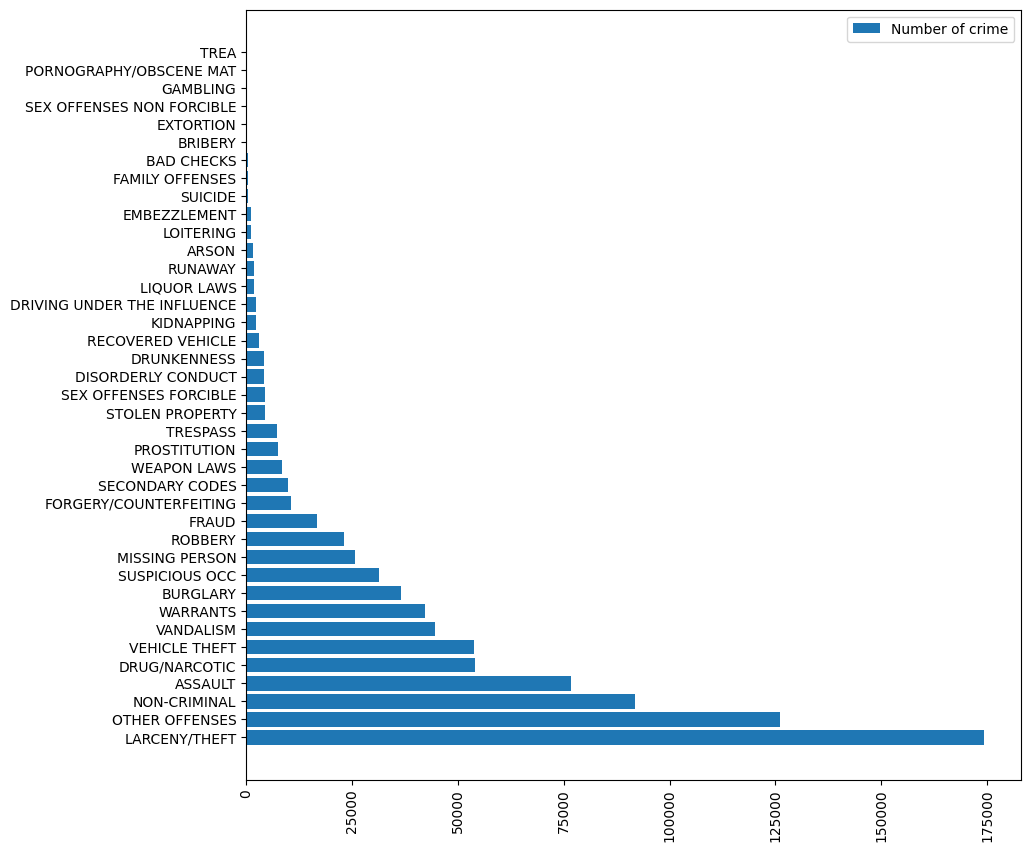

In [10]:
fig,ax=plt.subplots(figsize=(10,10))
ax.barh(y_value_counts.index,y_value_counts.values,label="Number of crime")
ax.legend()
plt.xticks(rotation=90)

plt.show()

### Dates & Day of the week

Dane są równomiernie rozłożone między 1 stycznia 2003 a 13 maja 2015 (oraz od poniedziałku do niedzieli). Nie zauważyliśmy żadnych anomalii w tych zmiennych.

In [11]:
df_train['Dates']=pd.to_datetime(df_train['Dates'])
df_train['Year']=df_train['Dates'].dt.year
df_train['Month']=df_train['Dates'].dt.month
df_train['Month_Name']=df_train['Dates'].dt.month_name()
df_train['Day']=df_train['Dates'].dt.day
df_train['Day_Name']=df_train['Dates'].dt.day_name()
df_train['Hour']=df_train['Dates'].dt.hour

In [12]:
day_of_week_value_counts=df_train['DayOfWeek'].value_counts()

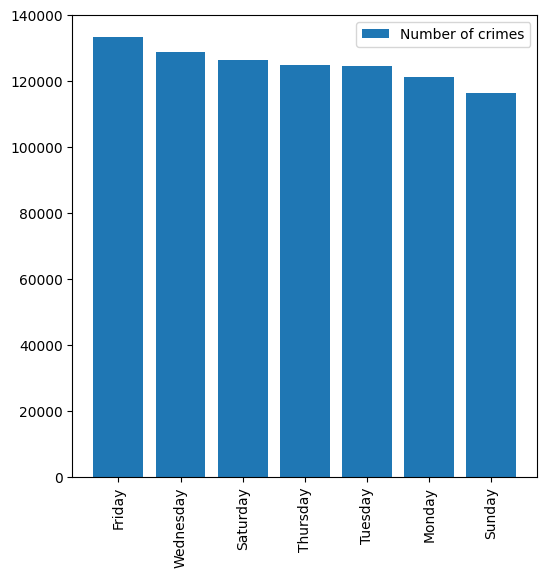

In [13]:
fig,ax=plt.subplots(figsize=(6,6))
ax.bar(day_of_week_value_counts.index,day_of_week_value_counts.values,label="Number of crimes")
ax.legend()
plt.xticks(rotation=90)

plt.show()

In [14]:
group_by_year=df_train.groupby(df_train['Year'])['Category'].size()

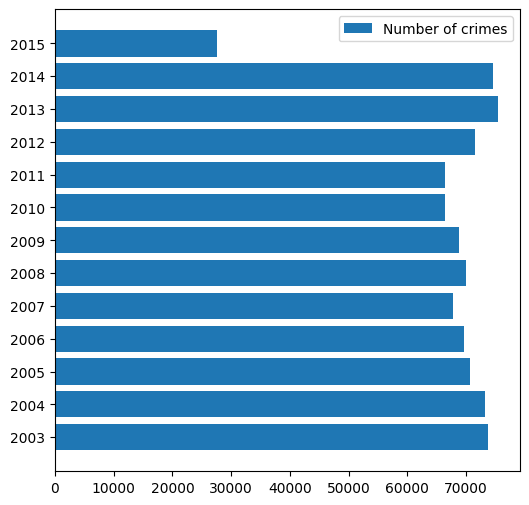

In [15]:
fig,ax=plt.subplots(figsize=(6,6))
ax.barh(group_by_year.index,group_by_year.values,label="Number of crimes")

ax.legend()
plt.yticks(group_by_year.index)

plt.show()

In [16]:
group_by_month=df_train.groupby(df_train['Month_Name'])['Category'].size().sort_values()

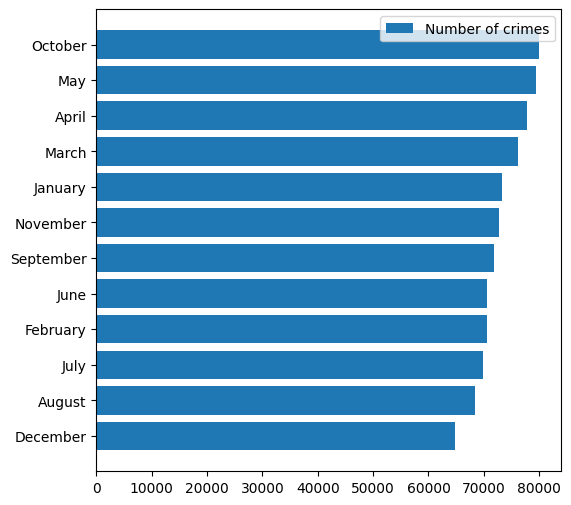

In [17]:
fig,ax=plt.subplots(figsize=(6,6))
ax.barh(group_by_month.index,group_by_month.values,label="Number of crimes")

ax.legend()

plt.show()

In [18]:
df_train.Dates.dt.date

0         2015-05-13
1         2015-05-13
2         2015-05-13
3         2015-05-13
4         2015-05-13
             ...    
878044    2003-01-06
878045    2003-01-06
878046    2003-01-06
878047    2003-01-06
878048    2003-01-06
Name: Dates, Length: 875726, dtype: object

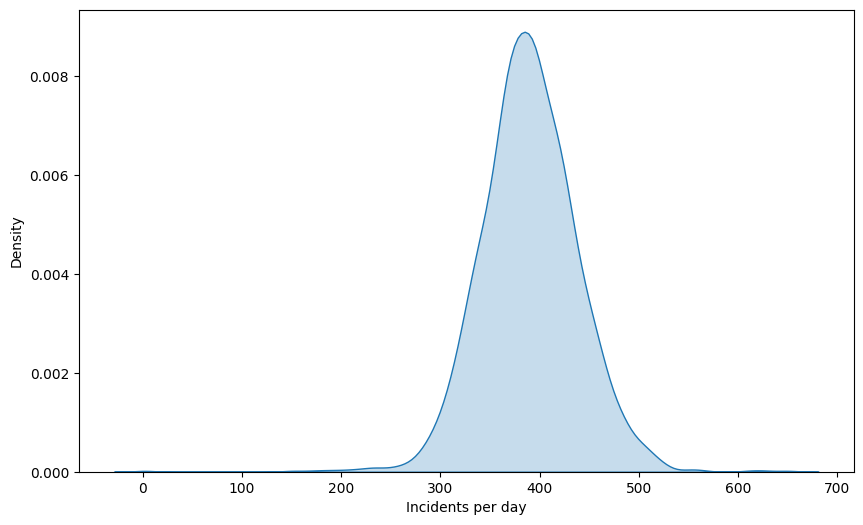

In [19]:
plt.figure(figsize=(10, 6))

density_Dates=df_train.groupby(df_train.Dates.dt.date)['Category'].count()
sns.kdeplot(data=density_Dates, fill=True)
plt.xlabel('Incidents per day')
plt.show()


nie widać znaczącej różnicy w wariancji więc zmienna nie powinna mieć dużego wpływu na przewidywana kategorię

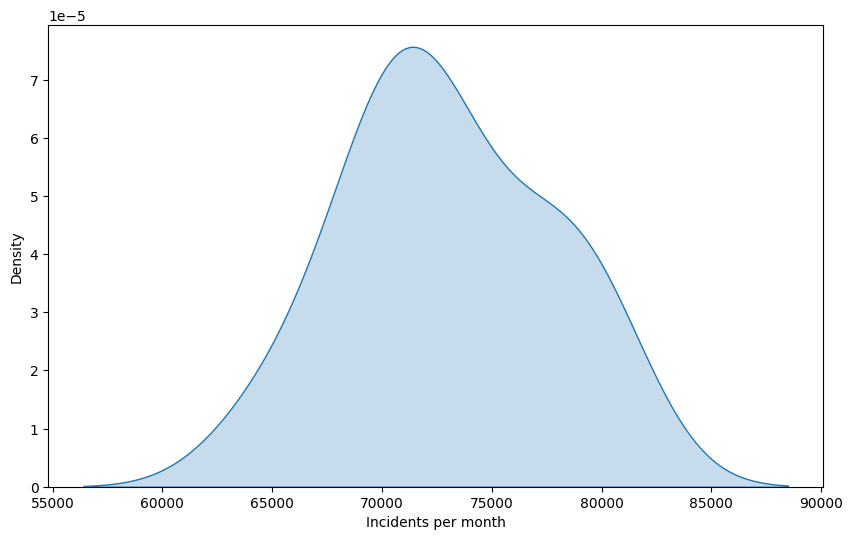

In [20]:
plt.figure(figsize=(10, 6))

density_Dates=df_train.groupby(df_train.Dates.dt.month)['Category'].count()
sns.kdeplot(data=density_Dates, fill=True)
plt.xlabel('Incidents per month')
plt.show()


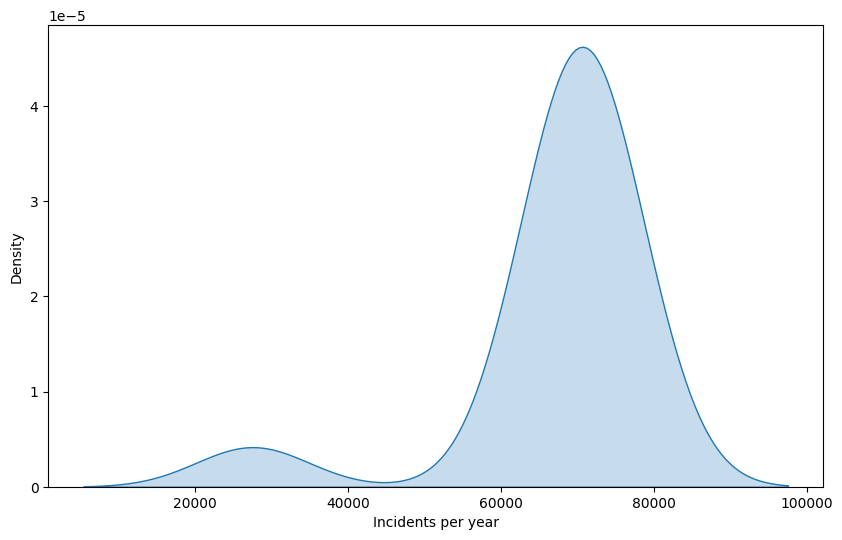

In [21]:
plt.figure(figsize=(10, 6))

density_Dates=df_train.groupby(df_train.Dates.dt.year)['Category'].count()
sns.kdeplot(data=density_Dates, fill=True)
plt.xlabel('Incidents per year')
plt.show()


In [22]:
top_ten_incidents=df_train.value_counts('Category')[:5].index


In [23]:
df_train_top_ten=df_train[df_train['Category'].isin(top_ten_incidents)]

<Axes: ylabel='Category,PdDistrict'>

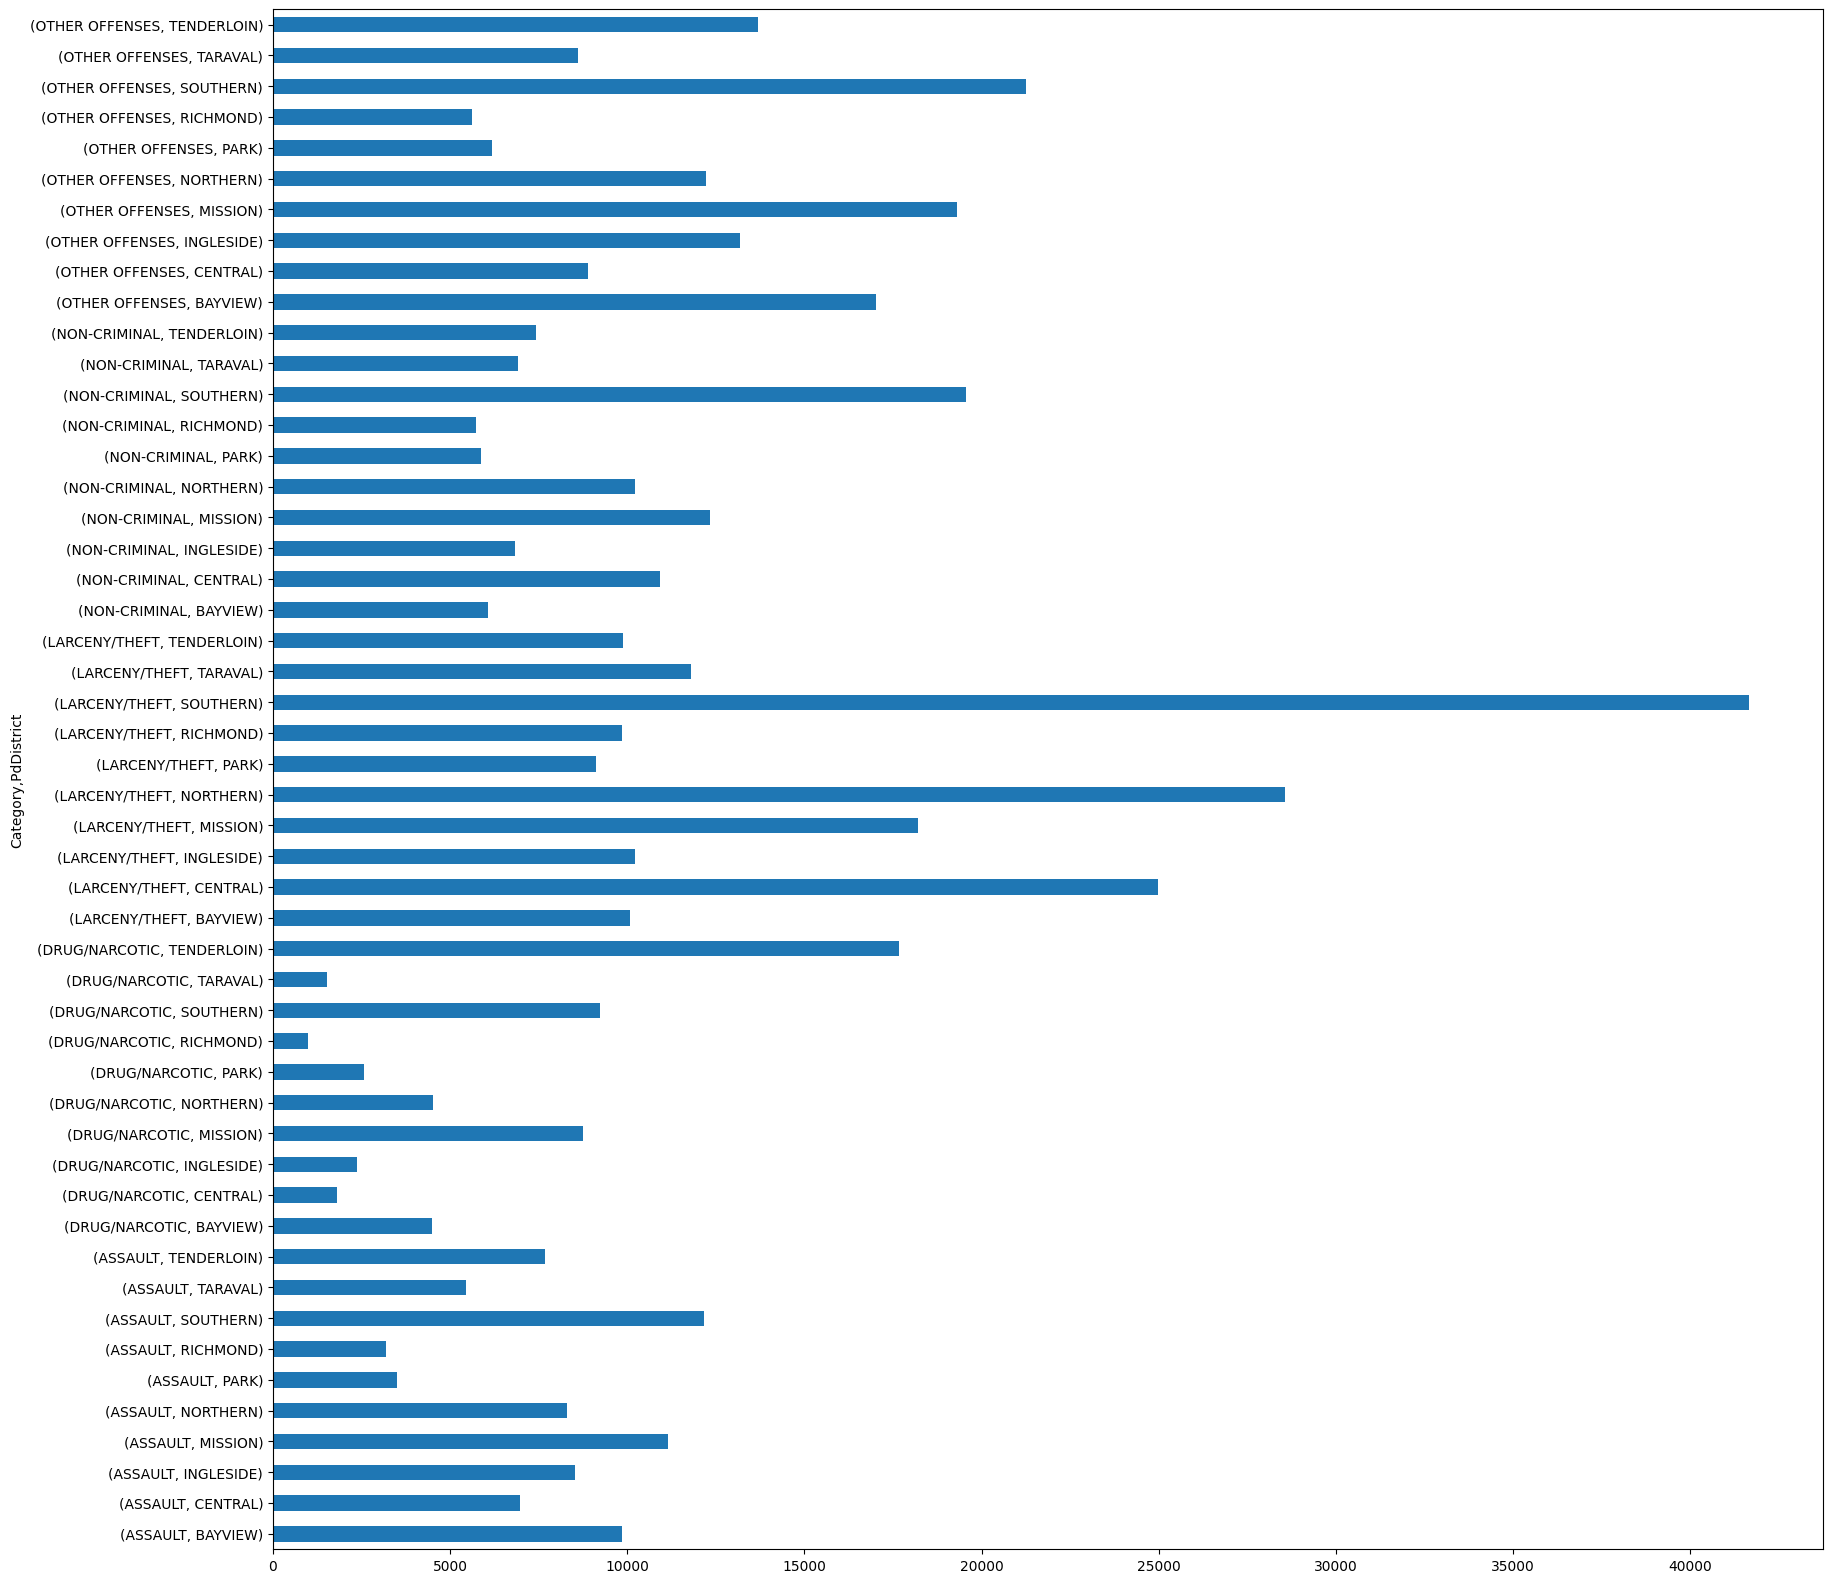

In [24]:
fig,ax=plt.subplots(figsize=(20,20))

df_train_top_ten.groupby(by=['Category','PdDistrict']).size().plot(kind="barh",ax=ax)



### X and Y
#### longitude & latitude

Przetestowaliśmy, czy współrzędne znajdują się w granicach miasta. Chociaż długość geograficzna nie zawiera żadnych wartości odstających, szerokość geograficzna zawiera kilka wartości 90°, które odpowiadają Biegunowi Północnemu. Nie tylko nasz zestaw treningowy zawiera te wartości odstające lecz rownież zestaw testowy. Z tego względu zdecydowaliśmy się zastąpić te wartości średnimi wartościami dla danego PdDistrict.

#### wyznaczanie outlier values

In [25]:
latitude = 37.77
longitude = -122.42

In [26]:
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12,tiles="cartodb positron")

sanfran_map
geo_json="https://data.sfgov.org/resource/d4vc-q76h.geojson"
response = requests.get(geo_json)
geojson_data = response.json()


In [27]:
folds = 10
colors = [mcolors.to_hex(plt.cm.Reds(i/float(folds))) for i in range(folds+1)]

x_min = df_train['X'].min()
x_max = df_train['X'].max()

bin_edges = np.linspace(x_min, x_max, folds)

df_train['sector'] = pd.cut(df_train['X'], bins=bin_edges,labels=False, include_lowest=True)
df_train.groupby('sector').size()

sector
0    875659
8        67
dtype: int64

In [28]:
outliers = df_train[df_train['sector']==8]

In [29]:
outliers['Y'].unique()

array([90.])

In [30]:
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12,tiles="cartodb positron")

incidents = folium.map.FeatureGroup()

for lat, lng, sector, cat in zip(outliers.Y, outliers.X, outliers['sector'], outliers['Category']):
    color = 'red'
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=folium.Popup(cat, parse_html=True),
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            opacity=0.7
        )
    )

sanfran_map.add_child(incidents)

sanfran_map

#### wizualizacja rozmieszczenia przestępstw

In [32]:
popup = folium.GeoJsonPopup(fields=["district"])

folium.GeoJson(
    data=geojson_data,
    popup=popup
).add_to(sanfran_map)




incidents = folium.map.FeatureGroup()

for lat, lng,cat in zip(df_train.Y[:1000], df_train.X[:1000],df_train['Category'][:1000]):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=cat,
            color='red',
            fill=True,
            opacity=0.2,
            fill_opacity=1,

            fill_color='red',
        )
    )

sanfran_map.add_child(incidents)
sanfran_map



### Police District

Istnieją znaczące różnice między różnymi dzielnicami, przy czym dzielnica Southern ma najwięcej incydentów (17,87%), a następnie Mission (13,67%) i Northern (12,00%).

In [33]:
pd_district_value_counts=df_train['PdDistrict'].value_counts()

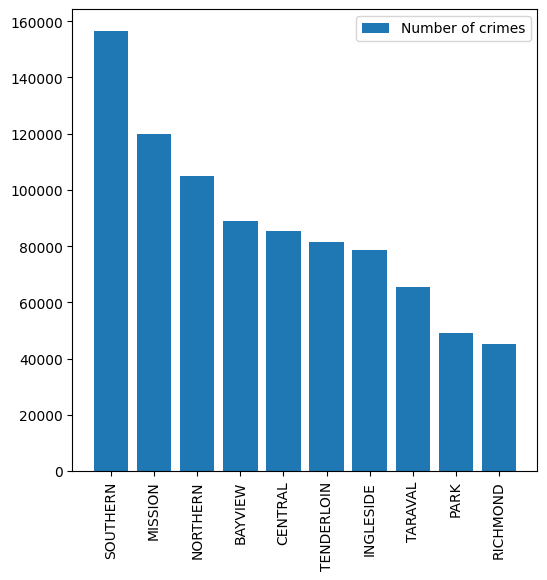

In [34]:
fig,ax=plt.subplots(figsize=(6,6))
ax.bar(pd_district_value_counts.index,pd_district_value_counts.values,label="Number of crimes")
ax.legend()
plt.xticks(rotation=90)

plt.show()

In [35]:
criminal_rate=df_train.groupby('PdDistrict')['Category'].count()
criminal_rate=criminal_rate/max(criminal_rate)
pd_criminal=pd.DataFrame({"Department":criminal_rate.index,"Rate":criminal_rate.values})

pd_criminal_dict = pd_criminal.set_index("Department")["Rate"]


<Axes: xlabel='DayOfWeek,PdDistrict'>

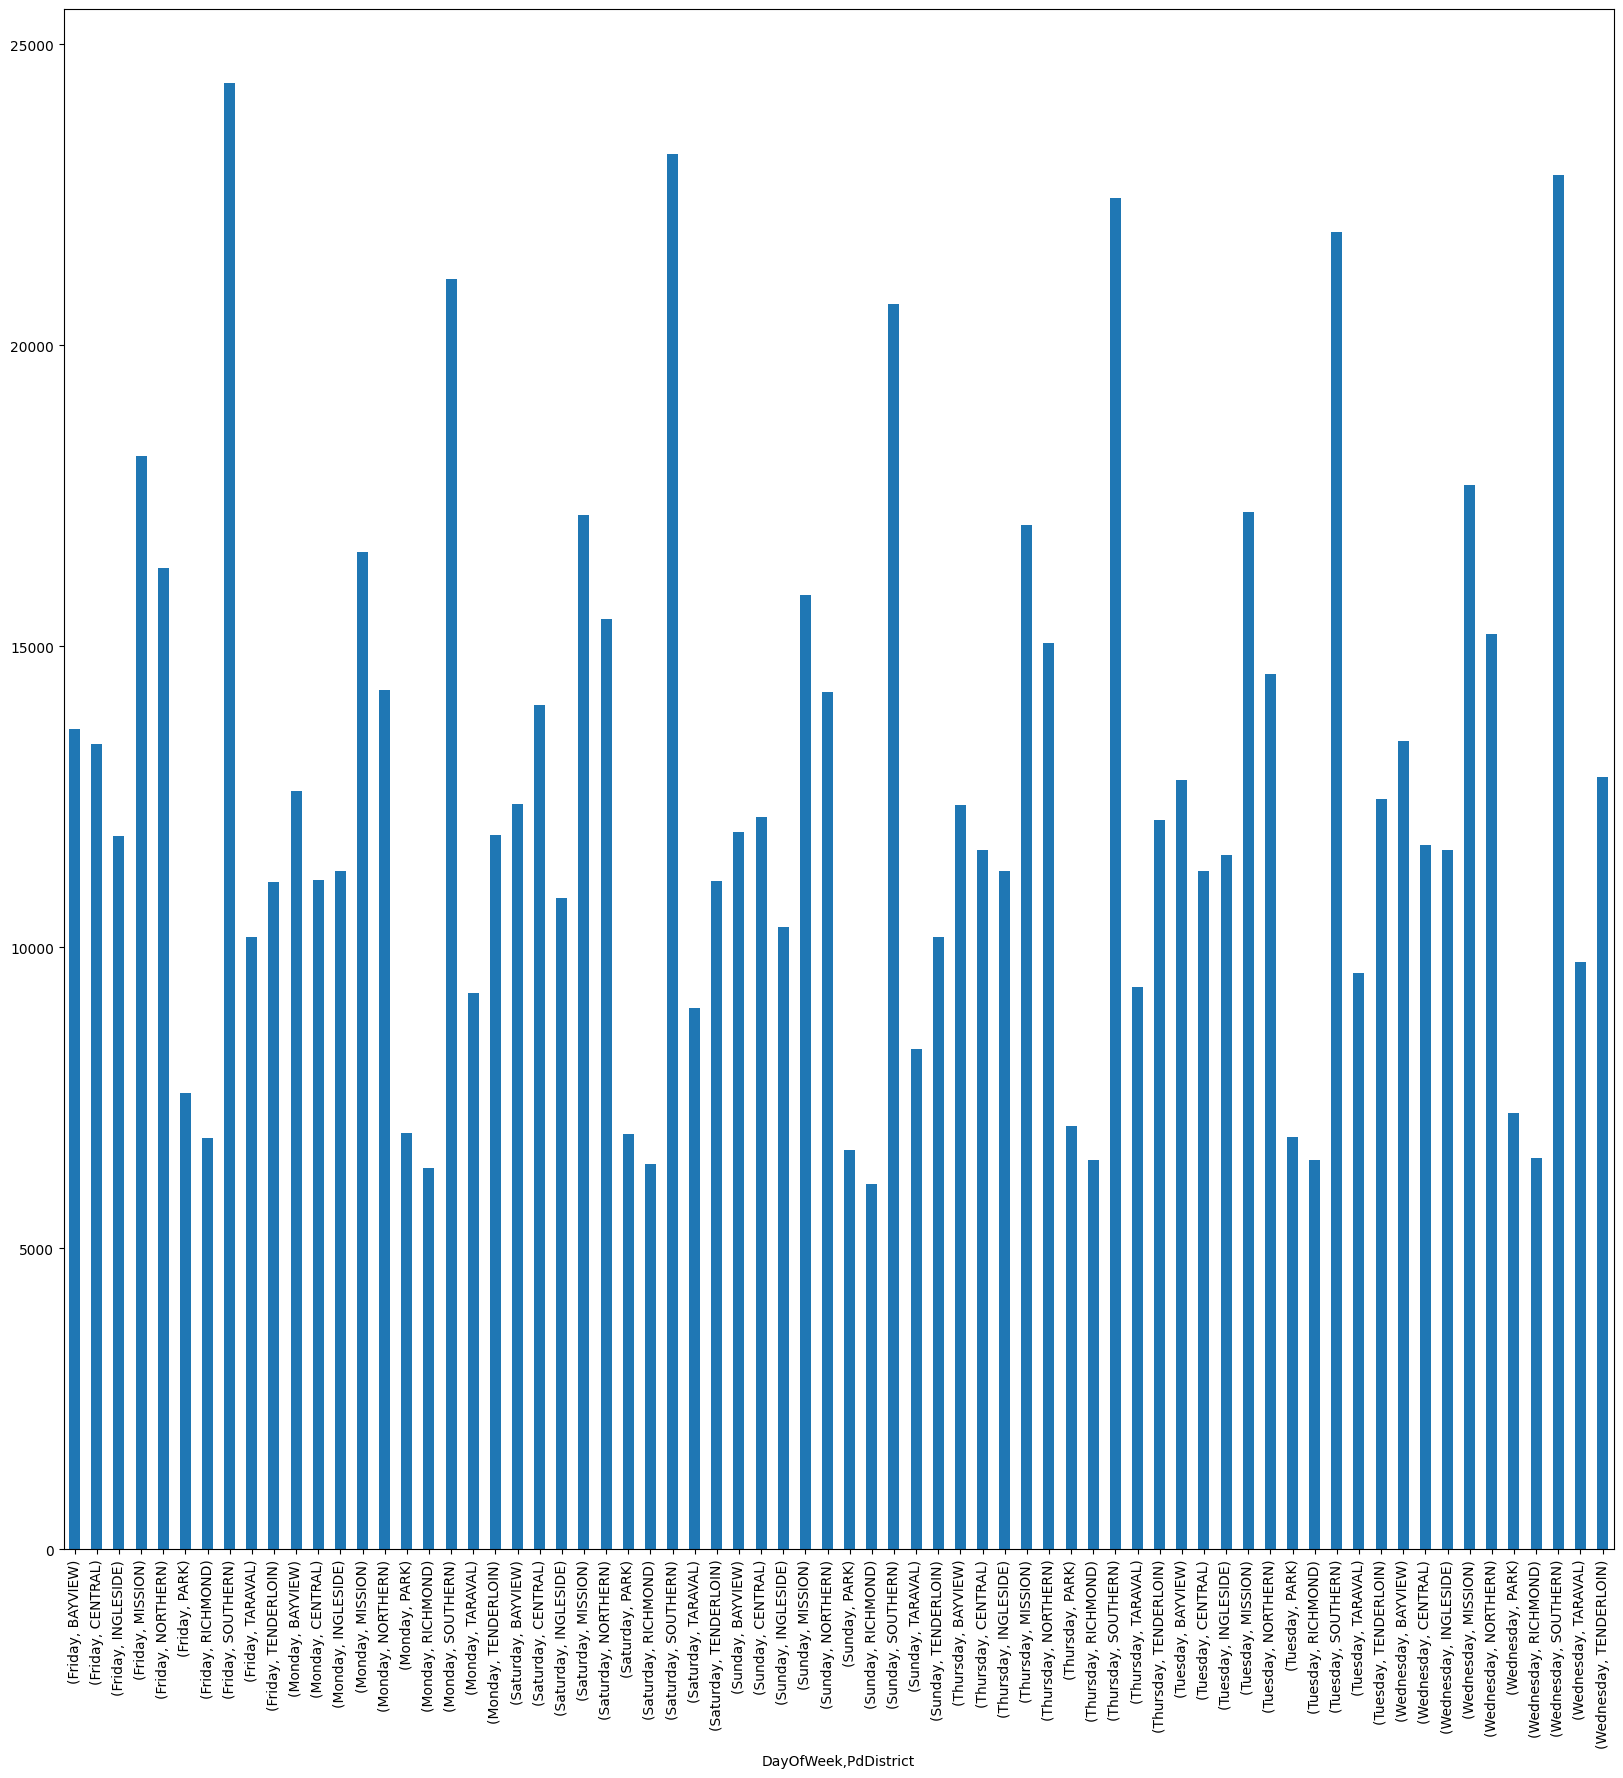

In [36]:
df_train.groupby(by=['DayOfWeek','PdDistrict']).size().plot(kind='bar',figsize=(20,20))

In [37]:

colormap = linear.YlGn_09.scale(
    pd_criminal.Rate.min(), pd_criminal.Rate.max()
)


In [38]:
popup = folium.GeoJsonPopup(fields=["district"])

sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12,tiles="cartodb positron")


folium.GeoJson(
    data=geojson_data,
    name="criminal_rate",
    style_function=lambda features: {
        "fillColor": colormap(pd_criminal_dict[features['properties']['district']]),
        "color": "black",
        "weight": 1,
        "dashArray": "5, 5",
        "fillOpacity": 0.9,
    },
    popup=popup

).add_to(sanfran_map)
folium.LayerControl().add_to(sanfran_map)
colormap.add_to(sanfran_map)

colormap.caption = "Criminal color scale"

sanfran_map

<iframe allow="geolocation" src="https://data.sfgov.org/dataset/Current-Police-Districts/wkhw-cjsf/embed?width=800&height=600" width="800" height="600" style="border:0; padding: 0; margin: 0;"></iframe>

### Przekształcanie Zmiennych Czasowych

Aby lepiej uchwycić cykliczne wzorce w danych, zastosowaliśmy funkcje trygonometryczne (sinus i cosinus) do przekształcenia dni i miesięcy. Dzięki temu udało się uwzględnić powiązania między różnymi okresami, takimi jak:

- **Miesiące**: Stworzenie związków między ciepłymi i zimnymi miesiącami. Dzięki temu nasz model może lepiej zrozumieć sezonowe wzorce w danych.
- **Dni tygodnia**: Uchwycenie różnic między weekendami a dniami roboczymi, co pozwala modelowi lepiej zrozumieć wzorce występowania przestępstw w różnych dniach tygodnia.
- **Godziny**: Stworzenie związków między godzinami dziennymi i nocnymi, co pozwala modelowi lepiej zrozumieć wzorce występowania przestępstw w różnych porach dnia.

Zastosowanie funkcji trygonometrycznych umożliwia efektywne kodowanie cykliczności w danych, co może poprawić wydajność modeli predykcyjnych.


In [39]:
df_train['months_norm'] = 2 * np.pi * (df_train['Month'] - 1) / 12
df_train['period_months'] = np.cos(df_train['months_norm']-0.2)

In [40]:
df_train['hours_norm'] = 2 * np.pi * df_train['Hour'] / 24
df_train['period_hours'] = np.cos(df_train['hours_norm'])

In [41]:
day_to_num = {
    'Monday': 1,
    'Tuesday': 0,
    'Wednesday': -1,
    'Thursday': 0,
    'Friday': 1,
    'Saturday': 2,
    'Sunday': 2
}

df_train["period_days"] = [day_to_num[day] for day in df_train['Day_Name']]

#### Miesiące

In [42]:
df_train_2014 = df_train[df_train["Year"]==2014]

Text(0.5, 1.0, 'Cos Wave - Month')

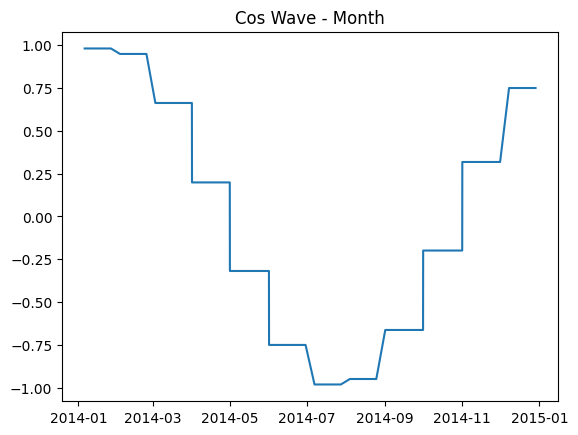

In [43]:
plt.plot(df_train_2014['Dates'], df_train_2014['period_months'])
plt.title('Cos Wave - Month')

#### Dni Tygodnia

In [44]:
df_train_2014_10 = df_train_2014[df_train_2014['Month']==10]

Text(0.5, 1.0, 'Periodic - Days')

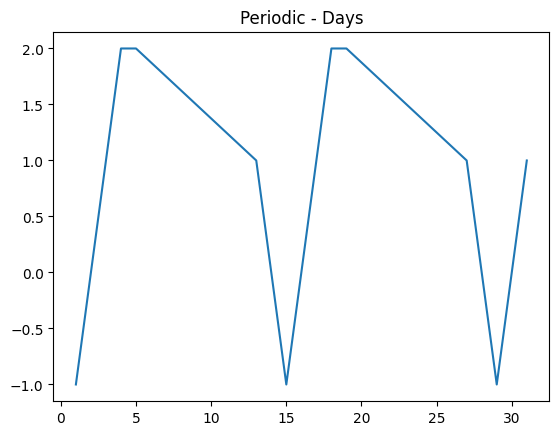

In [45]:
plt.plot(df_train_2014_10['Day'], df_train_2014_10['period_days'])
plt.title('Periodic - Days')

In [46]:
df_train_2014_10.groupby('Day').size()

Day
1     443
2     398
3     451
4     483
5     431
13    431
14    446
15    420
16    418
17    436
18    436
19    395
27    373
28    416
29    493
30    387
31    426
dtype: int64

#### Godziny

In [47]:
df_train_2014_10_13 = df_train_2014_10[df_train_2014_10['Day']==1]

Text(0.5, 1.0, 'Cos Wave - Hour')

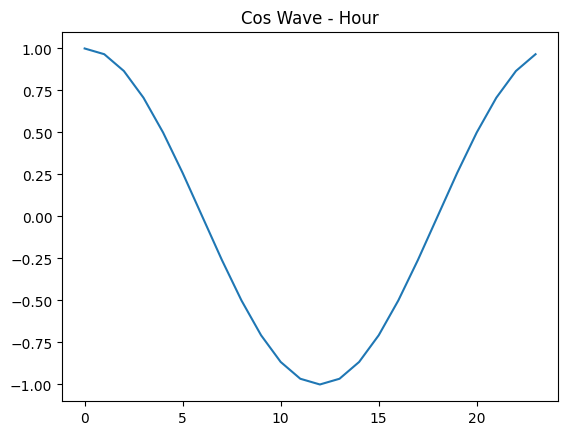

In [48]:
plt.plot(df_train_2014_10_13['Hour'], df_train_2014_10_13['period_hours'])
plt.title('Cos Wave - Hour')

#### Wizualizacja

In [49]:
monthly_crime_counts = df_train.groupby(['period_months', 'Category']).size().unstack(fill_value=0)
daily_crime_counts = df_train.groupby(['period_days', 'Category']).size().unstack(fill_value=0)
hourly_crime_counts = df_train.groupby(['period_hours', 'Category']).size().unstack(fill_value=0)


<Axes: xlabel='period_months', ylabel='Category'>

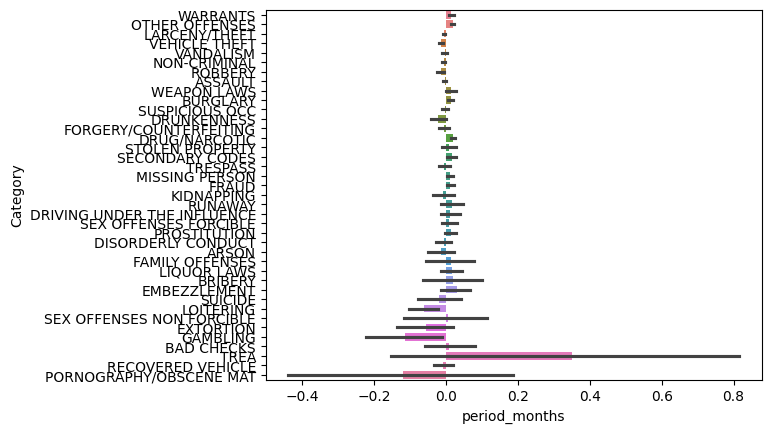

In [50]:
sns.barplot(x='period_months', y='Category', data=df_train, hue='Category',legend=False)

<Axes: xlabel='period_days', ylabel='Category'>

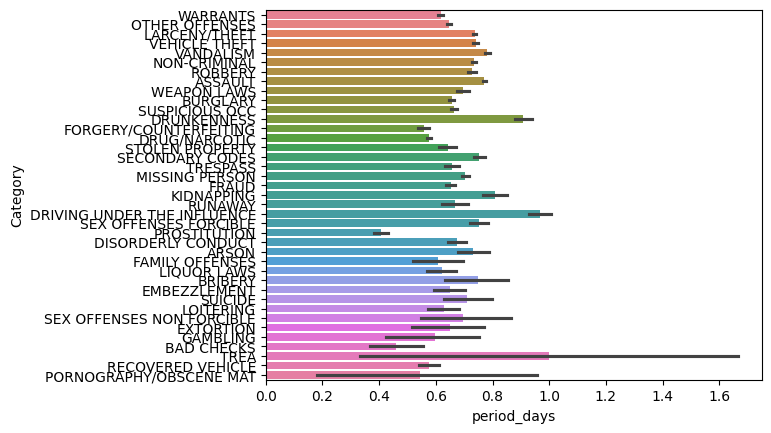

In [51]:
sns.barplot(x='period_days', y='Category', data=df_train, hue='Category',legend=False)

<Axes: xlabel='period_hours', ylabel='Category'>

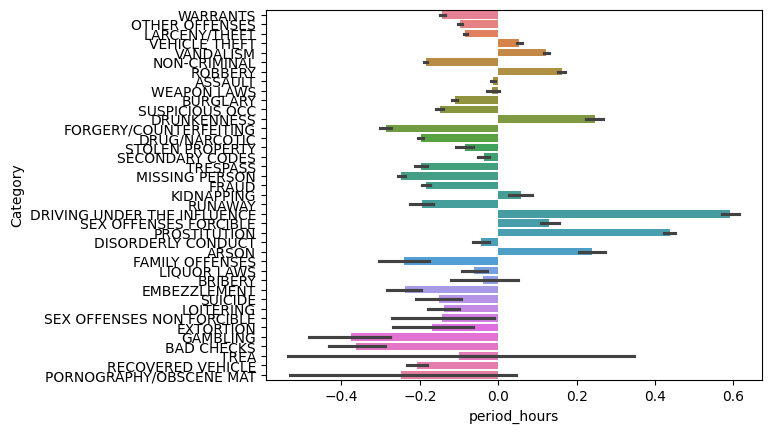

In [52]:
sns.barplot(x='period_hours', y='Category', data=df_train, hue='Category',legend=False)

### Bucketing

Aby lepiej uchwycić zależności przestrzenne w danych, zastosowaliśmy technikę grupowania (bucketing) współrzędnych geograficznych. Stworzyliśmy dwie nowe kolumny określające szerokość i długość geograficzną, podzielone na mniejsze segmenty (wiaderka). Dzięki temu można uwzględnić podobieństwa między miejscami znajdującymi się blisko siebie.

- **Szerokość geograficzna**: Podzieliliśmy wartości szerokości geograficznej na mniejsze segmenty, co pozwala na grupowanie blisko położonych punktów.
- **Długość geograficzna**: Podobnie podzieliliśmy wartości długości geograficznej, tworząc segmenty dla blisko położonych miejsc.

Technika grupowania pomaga modelowi lepiej zrozumieć przestrzenne wzorce w danych, co może prowadzić do bardziej dokładnych predykcji.

#### Szerokość geograficzna

In [53]:
x_min = df_train['X'].min()
x_max = df_train['X'].max()

bin_edges = np.linspace(x_min, x_max, folds)

df_train['sectors_X'] = pd.cut(df_train['X'], bins=bin_edges,labels=False, include_lowest=True)
df_train.groupby('sectors_X').size()

sectors_X
0     14570
1     23034
2     42297
3     51884
4    105419
5    241337
6    306715
7     81227
8      9176
dtype: int64

In [54]:
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12,tiles="cartodb positron")


incidents = folium.map.FeatureGroup()

for lat, lng, sector, cat in zip(df_train.Y[:1000], df_train.X[:1000], df_train['sectors_X'][:1000], df_train['Category'][:1000]):
    color = colors[sector]
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=folium.Popup(cat, parse_html=True),
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            opacity=0.7
        )
    )

sanfran_map.add_child(incidents)

sanfran_map

#### Długość geograficzna

In [55]:
x_min = df_train['Y'].min()
x_max = df_train['Y'].max()

bin_edges = np.linspace(x_min, x_max, folds)

df_train['sectors_Y'] = pd.cut(df_train['Y'], bins=bin_edges,labels=False, include_lowest=True)
df_train.groupby('sectors_Y').size()

sectors_Y
0     50449
1     69461
2     63577
3     73813
4    124217
5    215337
6    213877
7     58345
8      6583
dtype: int64

In [56]:
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12,tiles="cartodb positron")


incidents = folium.map.FeatureGroup()

for lat, lng, sector, cat in zip(df_train.Y[:1000], df_train.X[:1000], df_train['sectors_Y'][:1000], df_train['Category'][:1000]):
    color = colors[sector]
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=folium.Popup(cat, parse_html=True),
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            opacity=0.7
        )
    )

sanfran_map.add_child(incidents)

sanfran_map

# Preprocessing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.compose import ColumnTransformer

In [ ]:
df_train=pd.read_csv('train.csv')

In [ ]:
y_train = df_train['Category']
df_train = df_train.drop('Category', axis=1)

In [ ]:
df_train

Dates                Category  \
0       2015-05-13 23:53:00                WARRANTS   
1       2015-05-13 23:53:00          OTHER OFFENSES   
2       2015-05-13 23:33:00          OTHER OFFENSES   
3       2015-05-13 23:30:00           LARCENY/THEFT   
4       2015-05-13 23:30:00           LARCENY/THEFT   
...                     ...                     ...   
878044  2003-01-06 00:15:00                 ROBBERY   
878045  2003-01-06 00:01:00           LARCENY/THEFT   
878046  2003-01-06 00:01:00           LARCENY/THEFT   
878047  2003-01-06 00:01:00               VANDALISM   
878048  2003-01-06 00:01:00  FORGERY/COUNTERFEITING   

                                         Descript  DayOfWeek PdDistrict  \
0                                  WARRANT ARREST  Wednesday   NORTHERN   
1                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
2                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
3                    GRAND THEFT FROM LOCKED AUTO  Wednesday   NORTHERN   
4                    GRAND THEFT FROM LOCKED AUTO  Wednesday       PARK   
...                                           ...        ...        ...   
878044           ROBBERY ON THE STREET WITH A GUN     Monday    TARAVAL   
878045               GRAND THEFT FROM LOCKED AUTO     Monday  INGLESIDE   
878046               GRAND THEFT FROM LOCKED AUTO     Monday   SOUTHERN   
878047  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES     Monday   SOUTHERN   
878048                   CHECKS, FORGERY (FELONY)     Monday    BAYVIEW   

            Resolution                     Address           X          Y  
0       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599  
1       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599  
2       ARREST, BOOKED   VANNESS AV / GREENWICH ST -122.424363  37.800414  
3                 NONE    1500 Block of LOMBARD ST -122.426995  37.800873  
4                 NONE   100 Block of BRODERICK ST -122.438738  37.771541  
...                ...                         ...         ...        ...  
878044            NONE  FARALLONES ST / CAPITOL AV -122.459033  37.714056  
878045            NONE        600 Block of EDNA ST -122.447364  37.731948  
878046            NONE          5TH ST / FOLSOM ST -122.403390  37.780266  
878047            NONE        TOWNSEND ST / 2ND ST -122.390531  37.780607  
878048            NONE    1800 Block of NEWCOMB AV -122.394926  37.738212  

[878049 rows x 9 columns]

In [ ]:
class DateFeatureExtractor(BaseEstimator,TransformerMixin):
    def __init__(self, column):
        self.date_column_name = column
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X[self.date_column_name]=pd.to_datetime(X[self.date_column_name])
        X['day']=X[self.date_column_name].dt.day-1
        X['month']=X[self.date_column_name].dt.month-1
        X['year']=X[self.date_column_name].dt.year
        X['hour']=X[self.date_column_name].dt.hour
        X['quarter']=X[self.date_column_name].dt.quarter-1
        X['dayofyear']=X[self.date_column_name].dt.dayofyear-1
        X['dayofweek']=X[self.date_column_name].dt.dayofweek
        X['is_weekend'] = (
            X[self.date_column_name].dt.dayofweek >= 5).astype(int)
        X = X.drop(columns=[self.date_column_name])
        
        return X

In [ ]:
#month 12 -
#hour 24 -
#quarter 4 -
#dayofyear 365 -

class CosTransformation(BaseEstimator,TransformerMixin):
    def __init__(self, column, minus=False):
        self.period = None
        self.minus = minus
        self.column=column

    def fit(self, X, y=None):
        self.minus = -1 if self.minus else 1
        self.period=X[self.column].nunique()

        return self
    def transform(self,X,y=None):
        X[self.column+'cos'] = self.minus * \
            np.cos(X[self.column]*2*np.pi/self.period)
        return X


In [ ]:
#day 7 +


class SinTransformation(BaseEstimator, TransformerMixin):
    def __init__(self, column, minus=False):
        self.period = None
        self.minus = minus
        self.column = column

    def fit(self, X, y=None):
        self.minus = -1 if self.minus else 1
        self.period=X[self.column].nunique()
        return self

    def transform(self, X, y=None):
        X[self.column+'sin'] = self.minus * \
            np.sin(X[self.column]*2*np.pi/self.period)
        return X

In [ ]:
df_train

Dates                Category  \
0       2015-05-13 23:53:00                WARRANTS   
1       2015-05-13 23:53:00          OTHER OFFENSES   
2       2015-05-13 23:33:00          OTHER OFFENSES   
3       2015-05-13 23:30:00           LARCENY/THEFT   
4       2015-05-13 23:30:00           LARCENY/THEFT   
...                     ...                     ...   
878044  2003-01-06 00:15:00                 ROBBERY   
878045  2003-01-06 00:01:00           LARCENY/THEFT   
878046  2003-01-06 00:01:00           LARCENY/THEFT   
878047  2003-01-06 00:01:00               VANDALISM   
878048  2003-01-06 00:01:00  FORGERY/COUNTERFEITING   

                                         Descript  DayOfWeek PdDistrict  \
0                                  WARRANT ARREST  Wednesday   NORTHERN   
1                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
2                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
3                    GRAND THEFT FROM LOCKED AUTO  Wednesday   NORTHERN   
4                    GRAND THEFT FROM LOCKED AUTO  Wednesday       PARK   
...                                           ...        ...        ...   
878044           ROBBERY ON THE STREET WITH A GUN     Monday    TARAVAL   
878045               GRAND THEFT FROM LOCKED AUTO     Monday  INGLESIDE   
878046               GRAND THEFT FROM LOCKED AUTO     Monday   SOUTHERN   
878047  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES     Monday   SOUTHERN   
878048                   CHECKS, FORGERY (FELONY)     Monday    BAYVIEW   

            Resolution                     Address           X          Y  
0       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599  
1       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599  
2       ARREST, BOOKED   VANNESS AV / GREENWICH ST -122.424363  37.800414  
3                 NONE    1500 Block of LOMBARD ST -122.426995  37.800873  
4                 NONE   100 Block of BRODERICK ST -122.438738  37.771541  
...                ...                         ...         ...        ...  
878044            NONE  FARALLONES ST / CAPITOL AV -122.459033  37.714056  
878045            NONE        600 Block of EDNA ST -122.447364  37.731948  
878046            NONE          5TH ST / FOLSOM ST -122.403390  37.780266  
878047            NONE        TOWNSEND ST / 2ND ST -122.390531  37.780607  
878048            NONE    1800 Block of NEWCOMB AV -122.394926  37.738212  

[878049 rows x 9 columns]

In [ ]:
df_train.drop(columns=['Descript', 'Resolution','Address'], inplace=True)

In [ ]:
cos_transformer = Pipeline([
    ('cos_transformation_hour', CosTransformation(column='hour')),
    ('cos_transformation_month', CosTransformation(column='month')),
    ('cos_transformation_quarter', CosTransformation(column='quarter')),
    ('cos_transformation_dayofyear', CosTransformation(column='dayofyear')),
    ('cos_transformation_day', CosTransformation(column='day')),
    ('cos_transformation_dayofweek', CosTransformation(column='dayofweek'))
])
sin_transformer = Pipeline([
    ('sin_transformation_hour', SinTransformation(column='hour')),
    ('sin_transformation_month', SinTransformation(column='month')),
    ('sin_transformation_quarter', SinTransformation(column='quarter')),
    ('sin_transformation_dayofyear', SinTransformation(column='dayofyear')),
    ('sin_transformation_day', SinTransformation(column='day')),
    ('sin_transformation_dayofweek', SinTransformation(column='dayofweek'))

])

In [ ]:
class SphericalTransformation(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.x_mean=X[self.columns[0]].mean()
        self.y_mean=X[self.columns[1]].mean()
        self.x_std=X[self.columns[0]].std()
        self.y_std=X[self.columns[1]].std()

        return self

    def transform(self, X, y=None):
        x_norm=(X[self.columns[0]]-self.x_mean)/self.x_std
        y_norm=(X[self.columns[1]]-self.y_mean)/self.y_std
        X['r'] = np.sqrt(x_norm**2 + y_norm**2)
        X['theta'] = np.arctan(y_norm/x_norm)
        return X

In [ ]:
class BucketingCoordinatesTransformation(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['X', 'Y'],bins=10):
        self.columns = columns
        self.x_min=None
        self.x_max=None
        self.y_min=None
        self.y_max=None
        self.bins=bins
        self.bin_edges_x=None
        self.bind_edges_y=None
        self.x_mean=None
        self.y_mean=None
        self.x_std=None
        self.y_std=None

    def fit(self, X, y=None):
        self.x_mean=X[self.columns[0]].mean()
        self.y_mean=X[self.columns[1]].mean()
        self.x_std=X[self.columns[0]].std()
        self.y_std=X[self.columns[1]].std()
        
        self.x_min = ((X[self.columns[0]]-self.x_mean)/self.x_std).min()
        self.x_max = ((X[self.columns[0]]-self.x_mean)/self.x_std).max()
        self.y_min = ((X[self.columns[1]]-self.y_mean)/self.y_std).min()
        self.y_max = ((X[self.columns[1]]-self.y_mean)/self.y_std).max()

        self.bin_edges_x = np.linspace(self.x_min, self.x_max, self.bins)
        self.bin_edges_y = np.linspace(self.y_min, self.y_max, self.bins)

        return self

    def transform(self, X, y=None):
        
        X['sector_x'] = pd.cut((X[self.columns[0]]-self.x_mean)/self.x_std, bins=self.bin_edges_x,labels=False, include_lowest=True)
        X['sector_y'] = pd.cut((X[self.columns[1]]-self.y_mean)/self.y_std, bins=self.bin_edges_y,labels=False, include_lowest=True)

        return X

In [ ]:
date_transformer = Pipeline([
    ('date_features', DateFeatureExtractor(column='Dates')),
    ('cos', cos_transformer),
    ('sin', sin_transformer),
    ('spherical', SphericalTransformation(columns=['X','Y'])),
    #('bucketing', BucketingCoordinatesTransformation(columns=['X','Y'],bins=5))
])

In [ ]:
df_train

Dates                Category  DayOfWeek PdDistrict  \
0       2015-05-13 23:53:00                WARRANTS  Wednesday   NORTHERN   
1       2015-05-13 23:53:00          OTHER OFFENSES  Wednesday   NORTHERN   
2       2015-05-13 23:33:00          OTHER OFFENSES  Wednesday   NORTHERN   
3       2015-05-13 23:30:00           LARCENY/THEFT  Wednesday   NORTHERN   
4       2015-05-13 23:30:00           LARCENY/THEFT  Wednesday       PARK   
...                     ...                     ...        ...        ...   
878044  2003-01-06 00:15:00                 ROBBERY     Monday    TARAVAL   
878045  2003-01-06 00:01:00           LARCENY/THEFT     Monday  INGLESIDE   
878046  2003-01-06 00:01:00           LARCENY/THEFT     Monday   SOUTHERN   
878047  2003-01-06 00:01:00               VANDALISM     Monday   SOUTHERN   
878048  2003-01-06 00:01:00  FORGERY/COUNTERFEITING     Monday    BAYVIEW   

                 X          Y  
0      -122.425892  37.774599  
1      -122.425892  37.774599  
2      -122.424363  37.800414  
3      -122.426995  37.800873  
4      -122.438738  37.771541  
...            ...        ...  
878044 -122.459033  37.714056  
878045 -122.447364  37.731948  
878046 -122.403390  37.780266  
878047 -122.390531  37.780607  
878048 -122.394926  37.738212  

[878049 rows x 6 columns]

In [ ]:
df = date_transformer.fit_transform(df_train)
df

Category  DayOfWeek PdDistrict           X          Y  \
0                     WARRANTS  Wednesday   NORTHERN -122.425892  37.774599   
1               OTHER OFFENSES  Wednesday   NORTHERN -122.425892  37.774599   
2               OTHER OFFENSES  Wednesday   NORTHERN -122.424363  37.800414   
3                LARCENY/THEFT  Wednesday   NORTHERN -122.426995  37.800873   
4                LARCENY/THEFT  Wednesday       PARK -122.438738  37.771541   
...                        ...        ...        ...         ...        ...   
878044                 ROBBERY     Monday    TARAVAL -122.459033  37.714056   
878045           LARCENY/THEFT     Monday  INGLESIDE -122.447364  37.731948   
878046           LARCENY/THEFT     Monday   SOUTHERN -122.403390  37.780266   
878047               VANDALISM     Monday   SOUTHERN -122.390531  37.780607   
878048  FORGERY/COUNTERFEITING     Monday    BAYVIEW -122.394926  37.738212   

        day  month  year  hour  quarter  ...    daycos  dayofweekcos  \
0        12      4  2015    23        1  ... -0.758758     -0.222521   
1        12      4  2015    23        1  ... -0.758758     -0.222521   
2        12      4  2015    23        1  ... -0.758758     -0.222521   
3        12      4  2015    23        1  ... -0.758758     -0.222521   
4        12      4  2015    23        1  ... -0.758758     -0.222521   
...     ...    ...   ...   ...      ...  ...       ...           ...   
878044    5      0  2003     0        0  ...  0.528964      1.000000   
878045    5      0  2003     0        0  ...  0.528964      1.000000   
878046    5      0  2003     0        0  ...  0.528964      1.000000   
878047    5      0  2003     0        0  ...  0.528964      1.000000   
878048    5      0  2003     0        0  ...  0.528964      1.000000   

         hoursin  monthsin  quartersin  dayofyearsin    daysin  dayofweeksin  \
0      -0.258819  0.866025         1.0      0.634842  0.651372      0.974928   
1      -0.258819  0.866025         1.0      0.634842  0.651372      0.974928   
2      -0.258819  0.866025         1.0      0.634842  0.651372      0.974928   
3      -0.258819  0.866025         1.0      0.634842  0.651372      0.974928   
4      -0.258819  0.866025         1.0      0.634842  0.651372      0.974928   
...          ...       ...         ...           ...       ...           ...   
878044  0.000000  0.000000         0.0      0.092813  0.848644      0.000000   
878045  0.000000  0.000000         0.0      0.092813  0.848644      0.000000   
878046  0.000000  0.000000         0.0      0.092813  0.848644      0.000000   
878047  0.000000  0.000000         0.0      0.092813  0.848644      0.000000   
878048  0.000000  0.000000         0.0      0.092813  0.848644      0.000000   

               r     theta  
0       0.108186 -0.072455  
1       0.108186 -0.072455  
2       0.086313 -0.841086  
3       0.158368 -0.425271  
4       0.531113 -0.002147  
...          ...       ...  
878044  1.206207  0.103548  
878045  0.819764  0.104511  
878046  0.633727  0.031936  
878047  1.057250  0.019848  
878048  0.915093 -0.078552  

[878049 rows x 27 columns]

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder

In [ ]:
date_transformer = Pipeline([
    ('date_features', DateFeatureExtractor(column='Dates')),
    ('cos', cos_transformer),
    ('sin', sin_transformer),
    ('spherical', SphericalTransformation(columns=['X', 'Y'])),
    #('bucketing', BucketingCoordinatesTransformation(columns=['X','Y'],bins=5))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer_one_hot = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_transformer_label = Pipeline(steps=[
    ('label', OrdinalEncoder())
])

In [ ]:
df.columns

Index(['DayOfWeek', 'PdDistrict', 'X', 'Y', 'day', 'month', 'year', 'hour',
       'quarter', 'dayofyear', 'dayofweek', 'is_weekend', 'hourcos',
       'monthcos', 'quartercos', 'dayofyearcos', 'daycos', 'dayofweekcos',
       'hoursin', 'monthsin', 'quartersin', 'dayofyearsin', 'daysin',
       'dayofweeksin', 'r', 'theta'],
      dtype='object')

In [ ]:
df = date_transformer.fit_transform(df_train)

In [ ]:
df.drop(['DayOfWeek','day','month','hour','quarter'] ,axis=1,inplace=True)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['X', 'Y']),
        ('cat_one_hot', categorical_transformer_one_hot, ['PdDistrict']),
        ('cat_label', categorical_transformer_label, ['year']),
    ],remainder='passthrough')